In [57]:
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

In [58]:
tfd = tfp.distributions

# 1 Poisson Distribution

In [5]:
dist = tfp.distributions.poisson.Poisson(rate = 2)

In [6]:
vals = np.linspace(0, 10, 11)
vals

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [9]:
p = dist.prob(vals)
p

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([1.3533528e-01, 2.7067056e-01, 2.7067056e-01, 1.8044704e-01,
       9.0223521e-02, 3.6089405e-02, 1.2029802e-02, 3.4370853e-03,
       8.5927173e-04, 1.9094917e-04, 3.8189835e-05], dtype=float32)>

In [11]:
dist.mean().numpy()

2.0

In [14]:
dist.stddev().numpy()

1.4142135

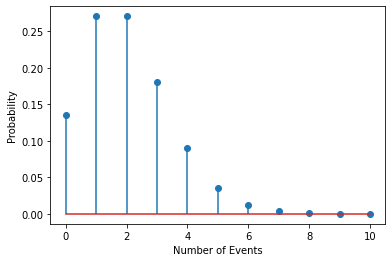

In [18]:
plt.stem(vals, p)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.show()

## Download fish dataset

In [32]:
# Load data from url
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)

In [33]:
dat

array([[ 1.        ,  0.        ,  0.        , ..., -0.89631456,
         3.05040479,  0.        ],
       [ 0.        ,  1.        ,  1.        , ..., -0.55834496,
         1.74614894,  0.        ],
       [ 0.        ,  1.        ,  0.        , ..., -0.40173101,
         0.27993888,  0.        ],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.39264885,
         0.67727542,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.37464058,
        -2.59563017,  0.        ],
       [ 1.        ,  1.        ,  1.        , ...,  0.82883412,
        -1.45711541,  0.        ]])

In [34]:
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]

In [35]:
X=np.array(X, dtype="float32")
y=np.array(y, dtype="float32")

Train - Test split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [44]:
print(f"X Train shape: {X_train.shape} / X Test shape: {X_test.shape}")

X Train shape: (200, 4) / X Test shape: (50, 4)


In [43]:
print(f"y Train shape: {y_train.shape} / y Test shape: {y_test.shape}")

y Train shape: (200,) / y Test shape: (50,)


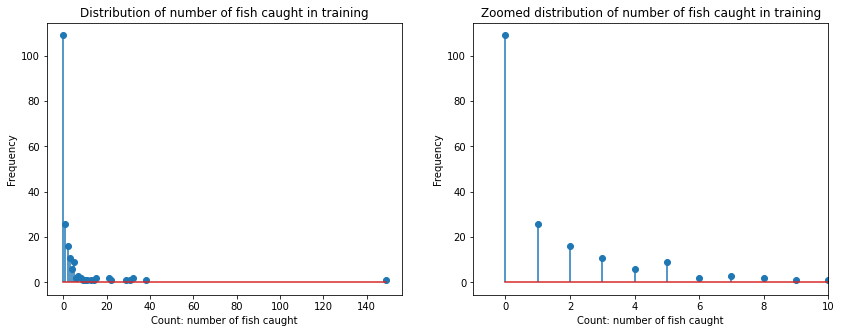

149.0

In [47]:
plt.figure(figsize=(14,5))

vals, counts = np.unique(y_train, return_counts=True)
plt.subplot(1,2,1)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.title('Distribution of number of fish caught in training')

plt.subplot(1,2,2)
plt.stem(vals, counts)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,10)
plt.title('Zoomed distribution of number of fish caught in training')
plt.show()

np.max(y_train)

We are interested in Group 31 and Group 33.

In [49]:
print(X_test[31])#"livebait","camper","persons","child
print(X_test[33])#"livebait","camper","persons","child
print(y_test[31])#"number of caught fish
print(y_test[33])#"number of caught fish

[1. 1. 4. 1.]
[1. 0. 4. 2.]
5.0
0.0


## Poissson Regression

In [59]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, 
         activation=tf.exp)(inputs) # This estimates the parameter lambda

p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate)

model_p = Model(inputs=inputs, outputs=p_y)


def NLL(y_true, y_hat):
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [60]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

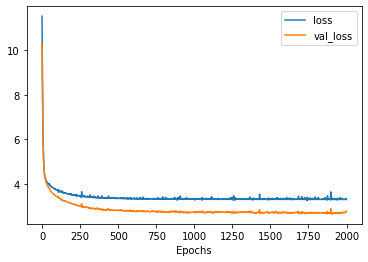

In [61]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

In [108]:
model = Model(inputs=inputs, outputs=p_y) 
y_hat_test = model(X_test).mean().numpy().flatten()


rmse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_p.evaluate(X_test, y_test) #returns the NLL 

2/2 [==============================] - 0s 3ms/step - loss: 2.7589


In [109]:
print(f"RMSE: {rmse} / MAE: {mae} / NLL: {NLL}")

RMSE: 7.407005786895752 / MAE: 3.046269416809082 / NLL: 2.7588934898376465


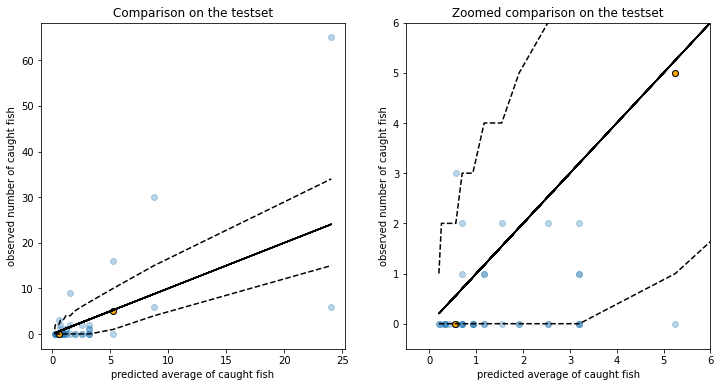

In [114]:
from scipy.stats import poisson
lower=poisson.ppf(0.025, y_hat_test)
upper=poisson.ppf(0.975, y_hat_test)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1,2,2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")
plt.title('Zoomed comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5,6])
plt.ylim([-0.5,6])
plt.show()

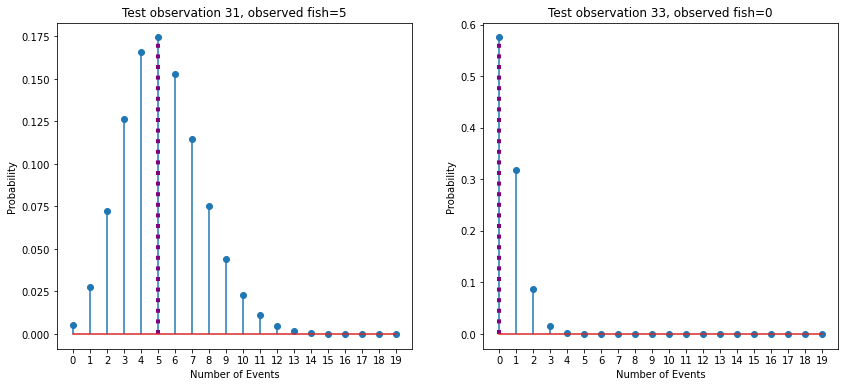

In [115]:
probs=model_p(X_test).prob(np.arange(0,20,1)).numpy()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.stem(np.arange(0,20,1),probs[31,:])
plt.xticks(np.arange(0,20,1))
plt.vlines(np.expand_dims(y_test,axis=1)[31], ymin=0, ymax=probs[31,np.int(y_test[31])],linestyle='dotted',color="purple",linewidth=4)

plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Test observation 31, observed fish=5')

plt.subplot(1,2,2)
plt.stem(np.arange(0,20,1),probs[33,:])
plt.xticks(np.arange(0,20,1))
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=probs[33,np.int(y_test[33])],linestyle='dotted',color="purple",linewidth=4)
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Test observation 33, observed fish=0')
plt.show()

## Zero inflated Poisson Regression

In [124]:
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

In [125]:
## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs) #A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done inside the zero_inf function
model_zi.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [130]:
optimizer=tf.optimizers.Adam(learning_rate=0.05)
steps=10
loss_values = np.zeros((steps))
for e in range(steps):
    with tf.GradientTape() as tape:
        y_hat = model_zi(X_train)
        loss_value = -tf.reduce_mean(y_hat.log_prob(y_train))
        loss_values[e] = loss_value
        grads = tape.gradient(loss_value, model_zi.trainable_weights)
        weights =  model_zi.trainable_weights       
        optimizer.apply_gradients(zip(grads,weights))
        print(loss_value)

tf.Tensor(3.8415873, shape=(), dtype=float32)
tf.Tensor(3.52611, shape=(), dtype=float32)
tf.Tensor(3.5225983, shape=(), dtype=float32)
tf.Tensor(3.5715122, shape=(), dtype=float32)
tf.Tensor(3.5660796, shape=(), dtype=float32)
tf.Tensor(3.50839, shape=(), dtype=float32)
tf.Tensor(3.4332392, shape=(), dtype=float32)
tf.Tensor(3.3747272, shape=(), dtype=float32)
tf.Tensor(3.351908, shape=(), dtype=float32)
tf.Tensor(3.358744, shape=(), dtype=float32)


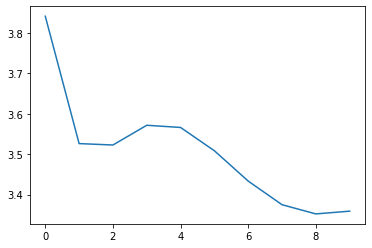

In [131]:
plt.plot(loss_values)

In [132]:
def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

In [133]:
model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

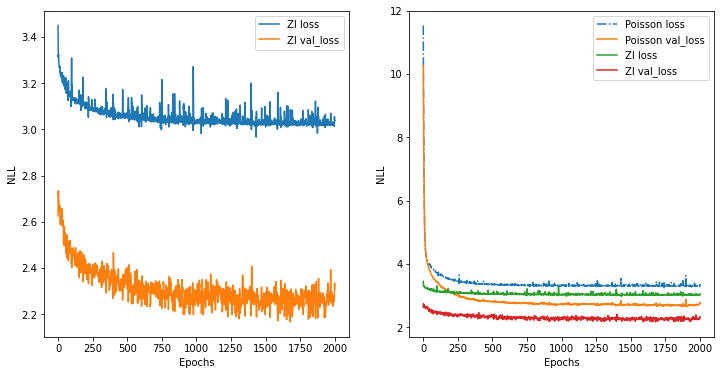

In [134]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['ZI loss','ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.subplot(1,2,2)
plt.plot(hist_p.history['loss'],linestyle='-.')
plt.plot(hist_p.history['val_loss'])
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['Poisson loss','Poisson val_loss','ZI loss','ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.show()

In [141]:
model = Model(inputs=inputs, outputs=p_y_zi) 
y_hat_test = model(X_test).mean().numpy().flatten()


rmse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_zi.evaluate(X_test, y_test) #returns the NLL 

2/2 [==============================] - 0s 3ms/step - loss: 2.3122


In [142]:
print(f"RMSE: {rmse} / MAE: {mae} / NLL: {NLL}")

RMSE: 7.478102207183838 / MAE: 3.1299092769622803 / NLL: 2.312150716781616


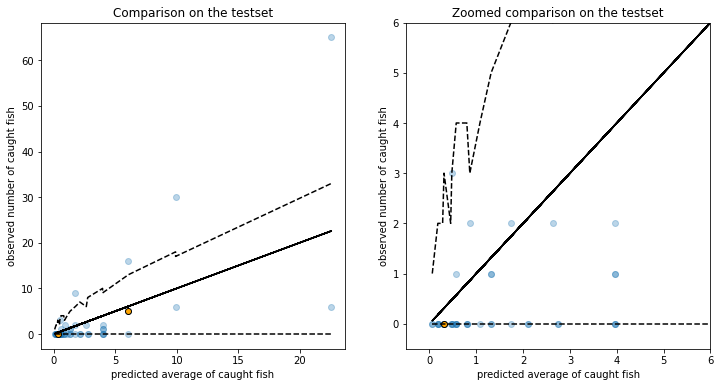

In [143]:
samples=model_zi(X_test).sample(5000).numpy()
lower=np.quantile(samples,0.025,axis=0)
upper=np.quantile(samples,0.975,axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")

plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1,2,2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")

plt.title('Zoomed comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5,6])
plt.ylim([-0.5,6])

plt.show()